# End-to-End Machine Learning Project

# Real-Word Case Study: Predicting House Prices


# SETUP : Importing Libraries and Methods

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew,norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# STEP 1 : Data Retrieval

In [88]:
# Load train and test data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [89]:
train.shape

(1460, 81)

In [90]:
test.shape

(1459, 80)

# Data Exploration

In [91]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [93]:
train.isna().sum().sum()

6965

In [94]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


skewness: 1.882876
kurtosis: 6.536282


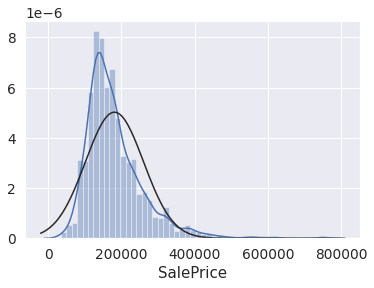

In [95]:
# kernel density plot
sns.distplot(train.SalePrice,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
print("skewness: %f" % train['SalePrice'].skew())
print("kurtosis: %f" % train ['SalePrice'].kurt())

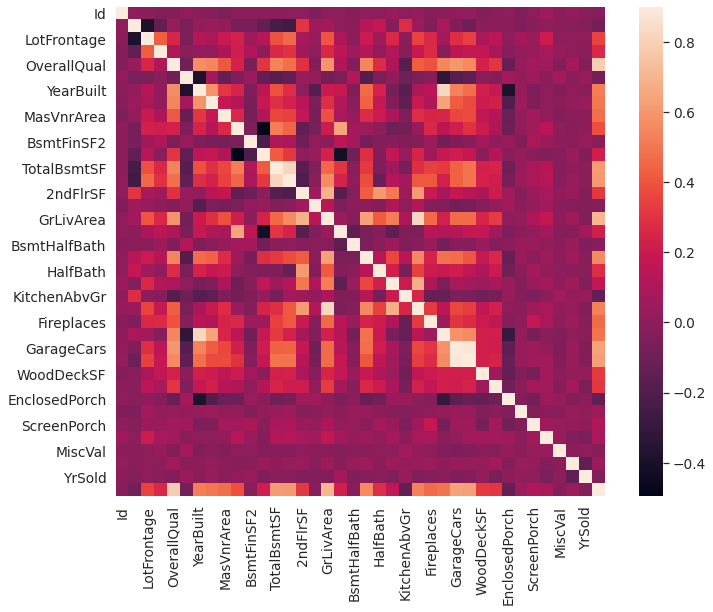

In [96]:
# explore correlation of variables
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmax=0.9, square=True)
plt.show();

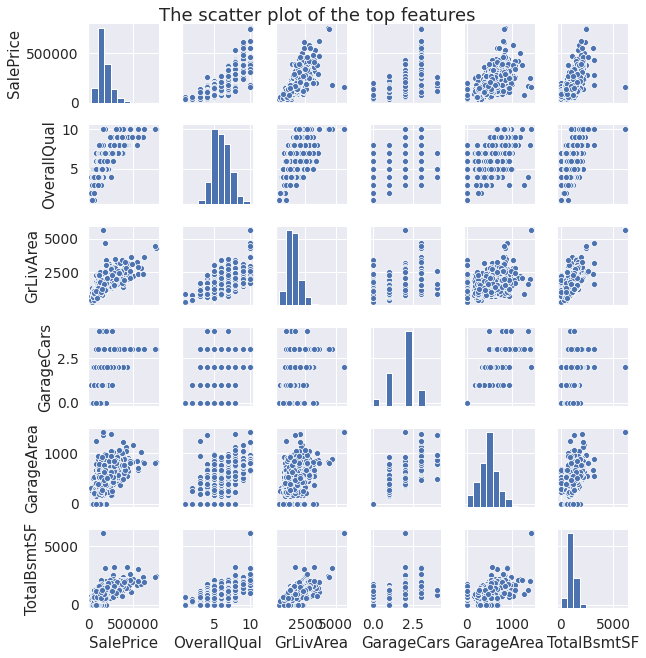

In [97]:
#Scatter plot of the most correlated features with SalePrice
cols = corrmat.nlargest(6, 'SalePrice')['SalePrice'].index
sns.pairplot(train[cols], size = 1.5)
plt.suptitle('The scatter plot of the top features ',x=0.5, y=1.01, verticalalignment='top', fontsize= 18)
plt.tight_layout()
plt.show()

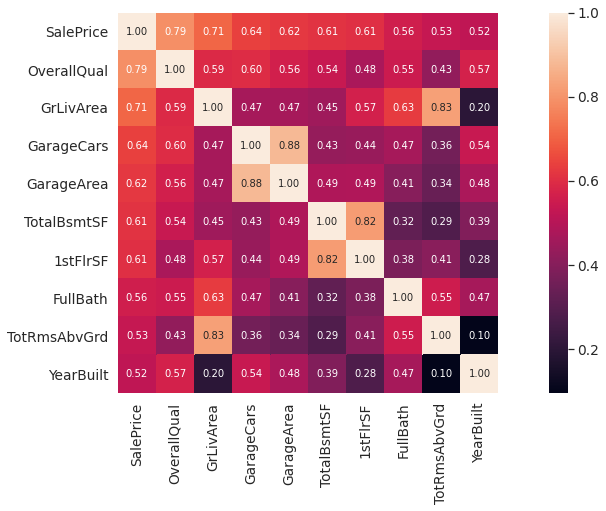

In [98]:
cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (18,7))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# STEP 2: Data Processing & Wrangling

In [0]:
#drop duplicate rows
train.drop_duplicates(inplace = True)

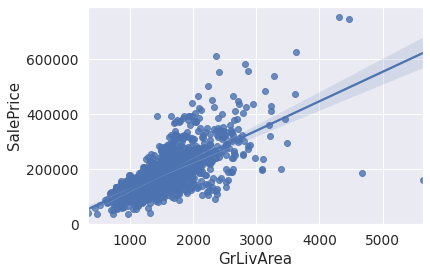

In [100]:
#Removing outliers from training
sns.regplot(x='GrLivArea',y='SalePrice',data=train)
plt.show()
train = train[train['GrLivArea'] < 4000]

In [0]:
#split data predicators and target
y_train = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

In [0]:
# pre-processing will be done on X
X = pd.concat([train,test])

In [0]:
I = test.Id

In [0]:
#save the ID column 
ID = X['Id']
#Drop the ID column since it is unnecessary for the prediction process
X.drop("Id",axis=1, inplace=True)

In [0]:
#There are some features which are categorical and whose missing values are meaningful
for i in ("Alley", "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu","GarageType", 
          "GarageFinish","GarageQual","GarageCond","Fence","PoolQC","MiscFeature",'MasVnrType','MSSubClass'):
    X[i].fillna("None", inplace=True)   

In [0]:
#Replacing missing value with 0 for no garage, no basement
for i in ('GarageYrBlt','GarageArea', 'GarageCars', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath','BsmtHalfBath','MasVnrArea'):
    X[i].fillna(0, inplace=True)    

In [107]:
#Setting Mode values for missing entries
for i in ('MSZoning','LotFrontage','Utilities','Exterior1st','Exterior2nd','Electrical','KitchenQual','Functional',
          'SaleType'):
    val = train[i].mode()[0]          ## estimate the mode from training data
    X[i].fillna(val, inplace=True)   
#check missing values
print('number of missing values=',X.isna().sum().sum())

number of missing values= 0


In [0]:
#drop very correlated features (>0.8)
X.drop('GarageArea', axis=1, inplace=True)
X.drop('TotRmsAbvGrd', axis=1, inplace=True)

In [0]:
# Casting types of variables from numerical to categorical
for i in ('MSSubClass','OverallCond','YrSold','MoSold'):
    X[i]= X[i].apply(str)

In [110]:
print('Data Shape:', X.shape)

Data Shape: (2915, 77)


# STEP 3: Feature Extraction & Engineering

In [0]:
#add new features
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X["TotalBath"] = X["BsmtFullBath"] + X["BsmtHalfBath"] + X["FullBath"] + X["HalfBath"]
X["AllSF"] = X["GrLivArea"] + X["TotalBsmtSF"]
X["AllFlrsSF"] = X["1stFlrSF"] + X["2ndFlrSF"]
X["AllPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]

In [0]:
X.drop('1stFlrSF', axis=1, inplace=True)

In [0]:
#get numerical features for scaling
numerical = X.select_dtypes(include=[np.number]).columns
#get numerical categorical features for encoding
categorical = X.select_dtypes(include=[object]).columns

In [114]:
#dummies encoding to categorical features
X = pd.get_dummies(X)
print('\nNumber of features:', len(X.columns))


Number of features: 341


In [0]:
#split data
train = pd.DataFrame(X[:train.shape[0]])
test = pd.DataFrame(X[train.shape[0]:])

# SETP 4: Feature Selection & Scaling

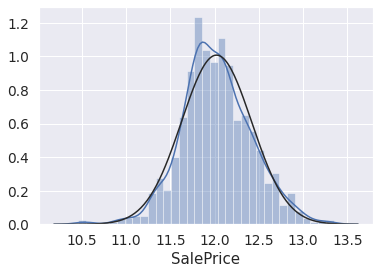

skewness: 0.065460
kurtosis: 0.666423


In [116]:
# Transform the whole distribution of target variable SalePrice
y_train = np.log1p(y_train)
#Kernel Density plot
sns.distplot(y_train,fit=norm)
plt.ylabel=('Frequency')
plt.xlabel=('SalePrice')
plt.show()
print("skewness: %f" % y_train.skew())
print("kurtosis: %f" % y_train.kurt())

In [0]:
#scaling predicators variable
scaler = MinMaxScaler().fit(train)                #fit on train data
train = scaler.transform(train)  #transorm train and test data
test = scaler.transform(test)

# SETP 5: Modeling

In [118]:
# split train dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size = 0.3, random_state = 32)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1019, 341), (437, 341), (1019,), (437,))

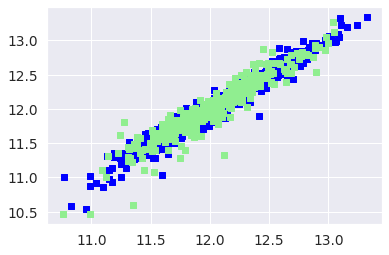

In [130]:
lin_reg = Ridge(alpha=1)
# train model
lin_reg.fit(X_train, y_train)
# predict
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)
# Plot predictions
fig=plt.figure()
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.show()

# SETP 6: Evaluation & Tuning

In [120]:
# evaluate by calculating r2_score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print((r2_train, r2_test))
#Ridge().get_params().keys() # get rdige hyperparamters

(0.9572048408298979, 0.8951745831520848)


GridSearchCV: best_score 0.911781225899083
GridSearchCV: best_params {'alpha': 5}
CV mean_score 0.9098039585516176


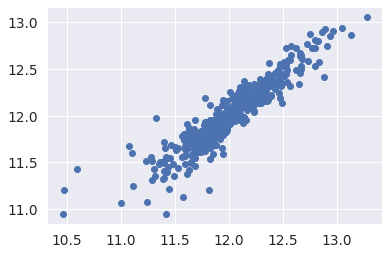

In [121]:
#GridSearchCV 
params = {'alpha':[25, 20, 15, 10, 5, 2.5, 1, 0.5]}
grid_obj = GridSearchCV(estimator=Ridge(), param_grid=params, cv=10, scoring='r2')
grid_obj.fit(X_train, y_train)
print("GridSearchCV: best_score", grid_obj.best_score_)
print("GridSearchCV: best_params", grid_obj.best_params_)
# Cross Validation
fold = KFold(n_splits=5, shuffle=True, random_state=32)
cv_scores = cross_val_score(grid_obj.best_estimator_, X_train, y_train, cv=fold, scoring='r2')
print("CV mean_score", cv_scores.mean())
y_pred = cross_val_predict(grid_obj.best_estimator_, X_test, y_test, cv=fold) #predict
scores = r2_score(y_test, y_pred)
fig = plt.figure()
plt.scatter(y_test, y_pred)
plt.show()

# SETP 7: Deployment

In [122]:
# Model persistence using joblib
import joblib
joblib.dump(grid_obj.best_estimator_, "best_ridge_price_prediction.pkl") 

['best_ridge_price_prediction.pkl']

In [0]:
# load model and make prediction on test dataset
my_model_loaded = joblib.load("best_ridge_price_prediction.pkl")
pred = my_model_loaded.predict(test)

In [0]:
pred_1 = lin_reg.predict(test)

In [0]:
pred_final = pd.DataFrame()
pred_final['Id'] = I
pred_final['SalePrice'] = pred_1

In [0]:
pred_final.to_csv('sub.csv',index= False)

In [127]:
pred_final.head()

,Id,SalePrice
0,1461,11.690197
1,1462,11.989963
2,1463,12.086632
3,1464,12.210734
4,1465,12.184728
